In [91]:
import requests
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/name/convex-community/volume-avalanche-test"
GRT_QUERY_ENDPOINT = "https://api.thegraph.com/subgraphs/id/QmdednjJY6HyGHQuN9jgFKJEPrAEh9f3oHgPQfN3gev21s"

def grt_query(query):
    r = requests.post(GRT_QUERY_ENDPOINT, json={'query': query})
    return r.json()['data']

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [92]:
fee_query = """
{ pools(first: 1000) {
  isV2
  id
  name
  dailyPoolSnapshots(first: 1000 orderBy: timestamp orderDirection: desc) {
    timestamp
    adminFeesUSD
    lpFeesUSD
    totalDailyFeesUSD
    eventFeesUSD
    baseApr
    tvl
  }
}
}
"""

In [93]:
data = grt_query(fee_query)['pools']
df = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df['totalDailyFeesUSD'] = df['totalDailyFeesUSD'].astype(float)
df['eventFeesUSD'] = df['eventFeesUSD'].astype(float) * 2
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')
df = df.sort_values('timestamp', ascending=True)
df

,isV2,id,name,timestamp,adminFeesUSD,lpFeesUSD,totalDailyFeesUSD,eventFeesUSD,baseApr,tvl
106,False,0x16a7da911a4dd1d83f3ff066fe28f3c792c50d90,Curve.fi avWBTC/renBTC,2021-10-05,0,0,0.00,0.00,0,2270400.554406010004696064728838022
339,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi avDAI/avUSDC/avUSDT,2021-10-05,0,0,0.00,0.00,0,105846509.083071062359793376
506,True,0xb755b949c126c04e0348dd881a5cf55d424742b2,Curve USD-BTC-ETH,2021-10-05,0,0,0.00,0.00,0,3213274.849910534691357204
338,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi avDAI/avUSDC/avUSDT,2021-10-06,12991.28489880945402135586709900578,12991.28489880945402135586709900578,25982.57,0.00,0.0001351613112763929549657889846406916,222251001.0032855439021031145070523
105,False,0x16a7da911a4dd1d83f3ff066fe28f3c792c50d90,Curve.fi avWBTC/renBTC,2021-10-06,357.4255771550259625207662075365859,357.4255771550259625207662075365859,714.85,0.00,0.0001662682217230428705656261334780966,3623047.628923178569871157783475743
...,...,...,...,...,...,...,...,...,...,...
158,False,0x30df229cefa463e991e29d42db0bae2e122b2ac7,Curve.fi Factory USD Metapool: MIM,2021-12-17,185.9092817499711244698117289398243,185.9092817499711244698117289398243,371.82,0.00,0.0002511350719882448949763804681321453,621313.3040224543276644503820219765
176,False,0x37c9be6c81990398e9b87494484afc6a4608c25d,Curve.fi Factory Plain Pool: blizz,2021-12-17,0,0,0.00,0.00,0.0003257220880971370714239148549668307,0
266,False,0x7f90122bf0700f9e7e1f688fe926940e8839f353,Curve.fi avDAI/avUSDC/avUSDT,2021-12-17,16925.48983997233619411632612782736,16925.48983997233619411632612782736,33850.98,0.00,0.0000920487851863326404370899379920065,693098273.5106015813226086604415743
591,False,0xf07d553b195080f84f582e88ecdd54baa122b279,Curve.fi Factory Plain Pool: Curve DD2Pool,2021-12-17,0,0,0.00,0.00,0,0


<AxesSubplot:xlabel='timestamp'>

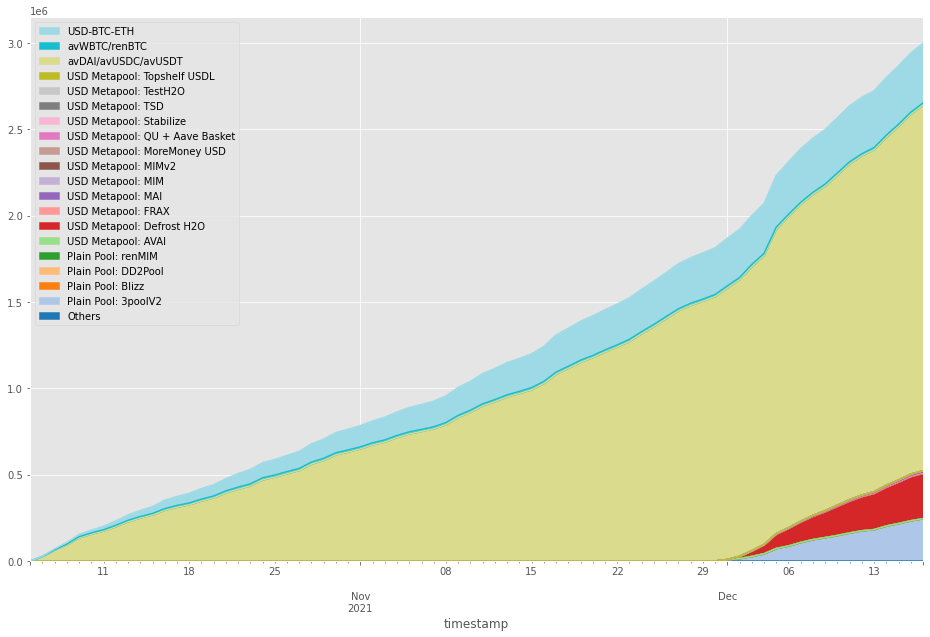

In [94]:
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data = df[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name', aggfunc='sum')
top_performers = chart_data.mean().sort_values(ascending=False)[:19].index.tolist()
df_others = df.copy()
df_others['name'] = df_others['name'].apply(lambda x: x if x in top_performers else 'Others')
df['cumulativeDailyFeesUSD'] = (df['totalDailyFeesUSD']).groupby(df['id']).cumsum()
chart_data_others = df_others[['name', 'timestamp', 'cumulativeDailyFeesUSD']].pivot_table('cumulativeDailyFeesUSD', ['timestamp'], 'name',  aggfunc='sum')
chart_data_others['Others'] = df_others[df_others['name'] == 'Others'][['timestamp', 'cumulativeDailyFeesUSD']].groupby('timestamp').sum()['cumulativeDailyFeesUSD']
chart_data_others.columns = [s.replace('Curve.fi Factory ', '').replace('Curve.fi ', '').replace('Curve ', '') for s in chart_data_others.columns]
cols = chart_data_others.columns.tolist()
chart_data_others[([cols[-1], *cols[1:-1], cols[0]])].plot.area(figsize=(16, 10), legend='reverse', colormap="tab20")

In [95]:
WEEK = 3600 * 24 * 7
df_week = pd.DataFrame([{k: v for k, v in dict({key: val for key, val in entry.items() if key in ['id', 'isV2', 'name']}, **snapshot).items()} for entry in data for snapshot in entry['dailyPoolSnapshots']])
df_week['totalDailyFeesUSD'] = df_week['totalDailyFeesUSD'].astype(float)
df_week['timestamp'] = df_week['timestamp'].apply(lambda x: ((int(x) // WEEK) * WEEK))
df_week['timestamp'] = pd.to_datetime(df_week['timestamp'],unit='s')
df_week = df_week.sort_values('timestamp', ascending=True)
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum()

,totalDailyFeesUSD
timestamp,
2021-09-30,28146.44
2021-10-07,238365.54
2021-10-14,175147.80
2021-10-21,192799.02
2021-10-28,197893.40
2021-11-04,208134.69
2021-11-11,267849.30
2021-11-18,265180.83
2021-11-25,294649.94


In [96]:
df_week[['totalDailyFeesUSD', 'timestamp', 'name', 'id']].groupby(['timestamp']).sum().sum() / 2

totalDailyFeesUSD   1498686.27
dtype: float64